In [14]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from scipy.stats import mode,zscore
from matplotlib import pyplot as plt


data = pd.read_json("../../data.json")
data.sample(2)

,index,mac,timestamp,no,rssi,raw,frequency,iq,angle,distance,capture,ref,a1,a2,a3,a2a1,a3a2,a3a1
16924,36,c300000a7a46,2024-11-10 18:04:25.933000+00:00,0,-66,0201061bff3906cafb0114fbffe9ff0a01000000000000...,2480,"[-168, 44, -17, -180, 170, 21, -46, 165, -145,...",75,465.874281,camila,"[2.885441271, -1.6649614575, 0.122906769600000...","[-0.9205688620000001, 2.9694018391, 0.92955255...","[1.5409544420999999, -0.5994524848, -2.8112952...","[-1.645127214, 2.4009407216, 0.2653320862, -1....","[2.4615233042, 2.7143309833, 2.5423374579, 2.6...","[3.0971036511, 3.0003932065, 3.076627385, 2.95...","[-0.7245583519000001, -0.5684611174, -0.664220..."
17669,178,c300000a7a46,2024-11-10 17:25:47.232000+00:00,0,-65,0201061bff3906cafb0114f9ffefff0701000000000000...,2426,"[73, 212, -214, 27, 26, -224, 223, 62, -77, 20...",90,1200.000000,camila,"[1.2391730325, 3.0160875733, -1.4552419851, 0....","[-2.4837040484, 1.4845245148, -0.6972876652000...","[1.3068326032, -0.9621070195, -3.1065193231, 0...","[-1.6211135313, 2.5421401687, 0.37787133710000...","[-2.4926486556, -2.4466315343, -2.4092316579, ...","[-2.9279461344, -2.778938119, -2.7987946470000...","[0.8625905172, 1.057615654, 1.0751590023, 1.00..."


# PD in each line and Post-Filtering

In [15]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error

tsamples =[]
tlabels =[]

vsamples=[]
vlabels=[]

tdataset, vdataset = train_test_split(data[data["capture"]== "tw"],test_size=0.2)

for row in tdataset.iterrows():
    for i in range(len(row[1]["a2a1"])):
        tsamples.append([
            row[1]["a2a1"][i], row[1]["a3a2"][i], row[1]["a3a1"][i]
        ])
        tlabels.append(row[1]["angle"])

for row in vdataset.iterrows():
    for i in range(len(row[1]["a2a1"])):
        vsamples.append([
            row[1]["a2a1"][i], row[1]["a3a2"][i], row[1]["a3a1"][i]
        ])
        vlabels.append(row[1]["angle"])

X_train = tsamples
y_train = tlabels#[label//15 for label in tlabels ]

X_test = vsamples
y_test = vlabels #[label//15 for label in vlabels ]


#array_names= ([str(name) for name in range(0,180+15,15)])

In [16]:

#Splitting the data into training and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#Creating an XGBoost classifier
model = xgb.XGBRegressor(enable_categorical=True)

#Training the model on the training data
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [17]:
#Making predictions on the test set
predictions = model.predict(X_test)

#Calculating accuracy
mae =mean_absolute_error(y_test, predictions)
mse =mean_squared_error(y_test, predictions)

print(f"{mae=}\n")
print(f"{mse=}\n")

mae=5.031983512519986

mse=153.6185676481803



In [32]:
results_labels= []
results_values = []
for row in vdataset.iterrows():
    pred=[]
    for i in range(len(row[1]["a2a1"])):
        pred.append(model.predict([[row[1]["a2a1"][i], row[1]["a3a2"][i], row[1]["a3a1"][i]],])[0])
    results_labels.append((row[1]["angle"]))
    results_values.append(np.mean(pred))

In [33]:
#Calculating accuracy
mae =mean_absolute_error(results_labels, results_values)
mse =mean_squared_error(results_labels, results_values)

print(f"{mae=}\n")
print(f"{mse=}\n")

mae=4.448719835755304

mse=87.1032086635175



In [34]:
results = {str(l):[] for l in set(vlabels)}

for row in vdataset.iterrows():
    pred=[]
    for i in range(len(row[1]["a2a1"])):
        pred.append(model.predict([[row[1]["a2a1"][i], row[1]["a3a2"][i], row[1]["a3a1"][i]],])[0])
    results[str(row[1]["angle"])].append(np.mean(pred))

In [35]:
# for key, values in results.items():
#     print(f"Angulo {key}\n" )
#     print(f"\t media = {np.mean(values)} \t std = {np.std(values)} \t variance ={np.var(values)} ")

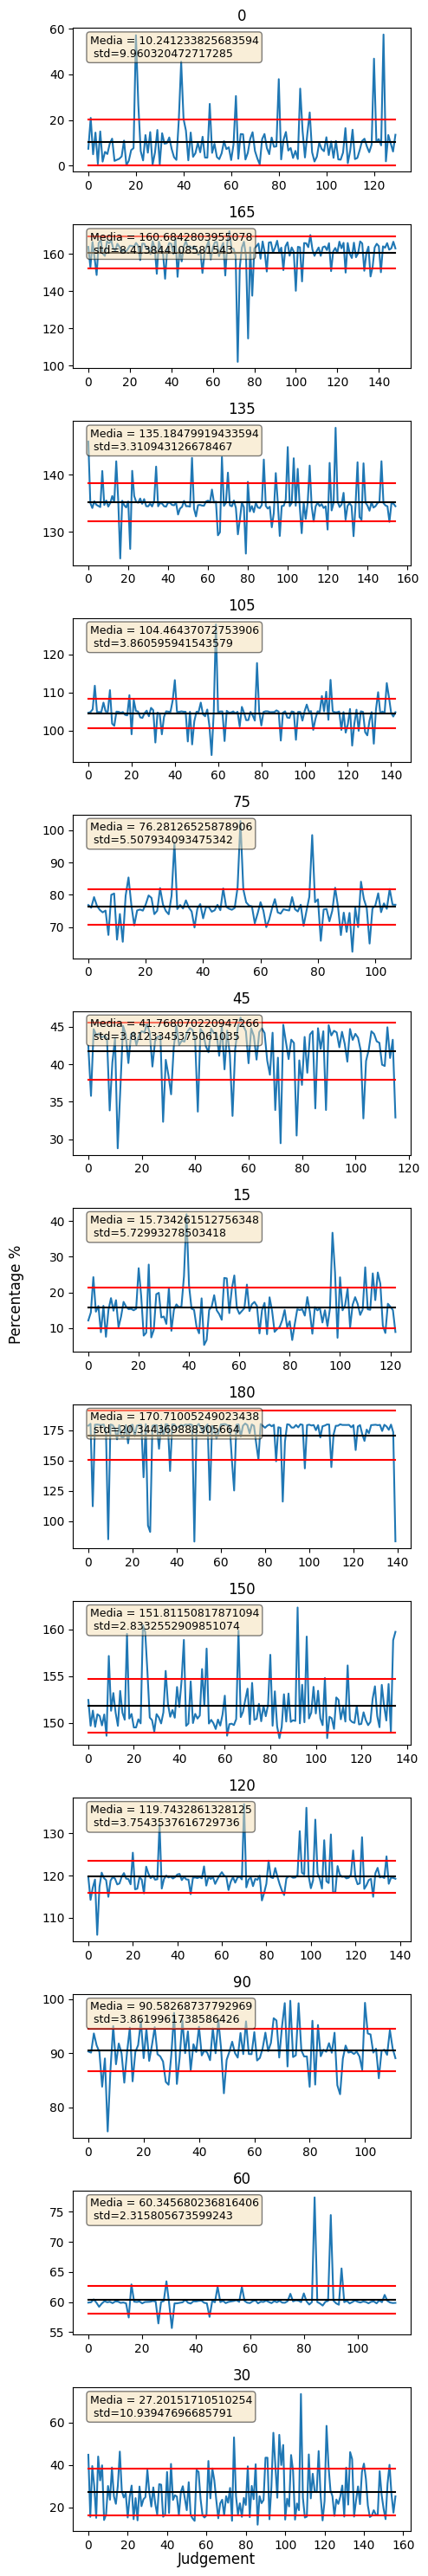

In [36]:
fig, ax = plt.subplots(len(set(results.keys())),figsize=(5,30))
fig.set_tight_layout(True)

fig.supylabel("Percentage %")
fig.supxlabel("Judgement")

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
for i, pair in enumerate(results.items()):
    ax[i].title.set_text(pair[0])
    ax[i].plot(pair[1])
    ax[i].plot([np.mean(pair[1])]*len(pair[1]),'k')
    ax[i].plot([np.mean(pair[1])+np.std(pair[1])]*len(pair[1]),'r')
    ax[i].plot([np.mean(pair[1])-np.std(pair[1])]*len(pair[1]),'r')

    ax[i].text(0.05, 0.95, f"Media = {np.mean(pair[1])}\n std={np.std(pair[1])}", transform=ax[i].transAxes, fontsize=9,
        verticalalignment='top', bbox=props)


In [37]:
results = {str(l):[] for l in set(vlabels)}

for row in vdataset.iterrows():
    pred=[]
    for i in range(len(row[1]["a2a1"])):
        pred.append(model.predict([[row[1]["a2a1"][i], row[1]["a3a2"][i], row[1]["a3a1"][i]],])[0])
    pred = np.array(pred)

    pred = pred[zscore(pred)<2]
    results[str(row[1]["angle"])].append(np.mean(pred))
    

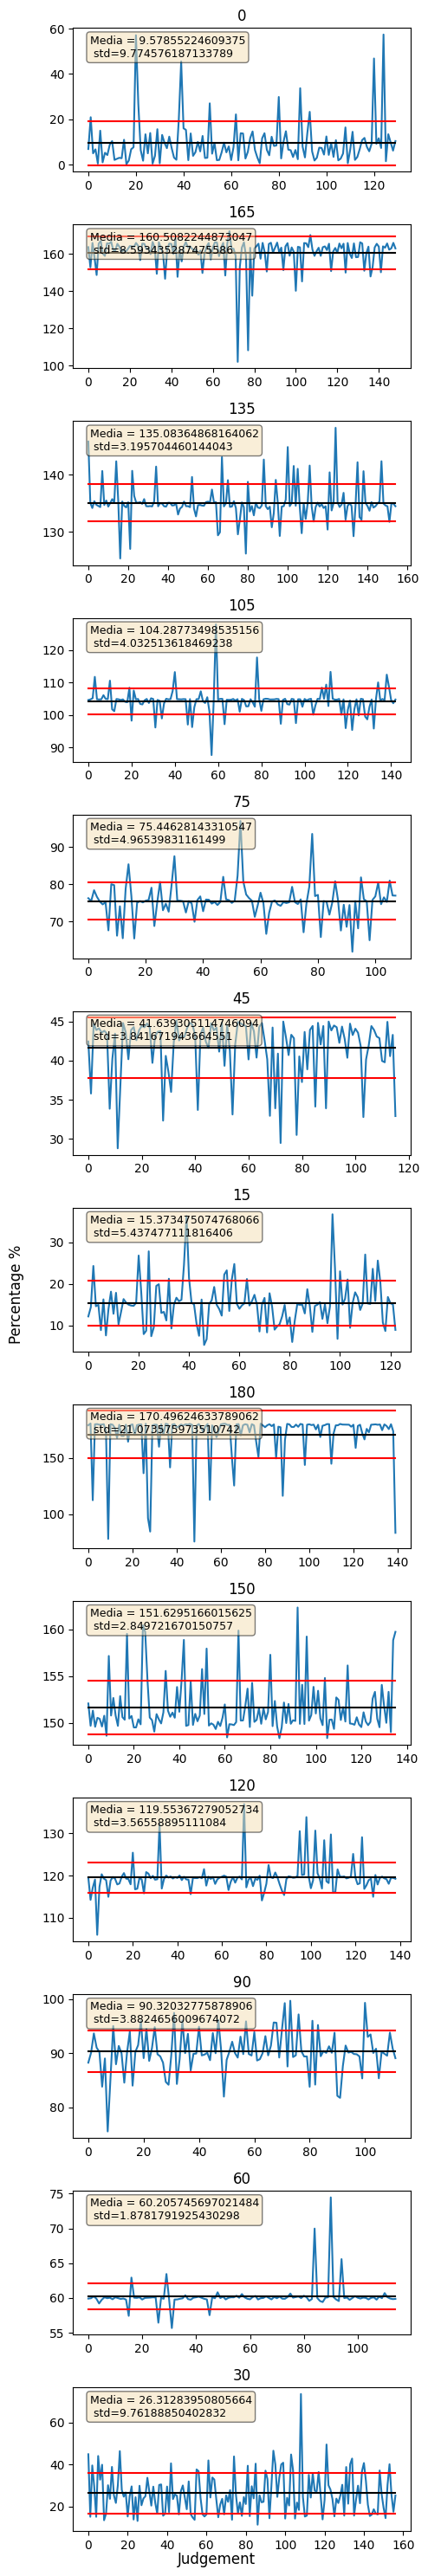

In [38]:
fig, ax = plt.subplots(len(set(results.keys())),figsize=(5,30))
fig.set_tight_layout(True)

fig.supylabel("Percentage %")
fig.supxlabel("Judgement")

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
for i, pair in enumerate(results.items()):
    ax[i].title.set_text(pair[0])
    ax[i].plot(pair[1])
    ax[i].plot([np.mean(pair[1])]*len(pair[1]),'k')
    ax[i].plot([np.mean(pair[1])+np.std(pair[1])]*len(pair[1]),'r')
    ax[i].plot([np.mean(pair[1])-np.std(pair[1])]*len(pair[1]),'r')

    ax[i].text(0.05, 0.95, f"Media = {np.mean(pair[1])}\n std={np.std(pair[1])}", transform=ax[i].transAxes, fontsize=9,
        verticalalignment='top', bbox=props)


In [39]:
model.save_model("./xbg_regressor.json")